In [6]:
# IMAGE PROCESSING
import cv2 # OpenCV library
import numpy as np # Numpy library for matricies
import random
import math
from matplotlib import pyplot as plt # Matplotlib library for plotting
from collections import deque
import heapq

random.seed(42)

In [11]:
# General settings
seed = 42
image_file = "official.png"

# Occupancy map
unsafe_iterations = 3

# BFS
size_of_node_grid = 9
bfs_start_node = 0
bfs_end_node = 99

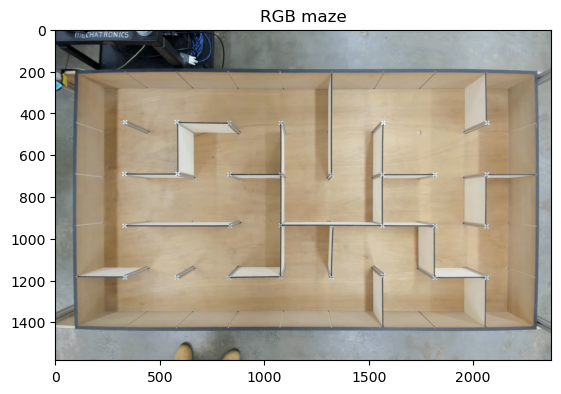

In [12]:
image = cv2.imread(image_file)
rgb_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.title("RGB maze")
plt.show()

[[ 1.01351351e+00 -1.80411242e-16 -9.12162162e+01]
 [-1.11022302e-16  1.00401606e+00 -1.90763052e+02]
 [-6.77626358e-20 -7.31836466e-19  1.00000000e+00]]


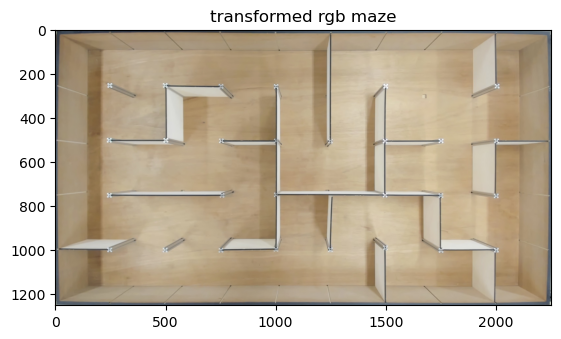

In [30]:
pts1 = np.float32([[90,190],[2310,190],[90,1435],[2310,1435]]) # original img corners
pts2 = np.float32([[0,0],[2250,0],[0,1250],[2250,1250]]) # warped corners

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
print(H)

warped_img = cv2.warpPerspective(image, H, (2251,1251)) # 250*9 x 250*5
warped_rgb = cv2.cvtColor(warped_img,cv2.COLOR_BGR2RGB)
plt.imshow(warped_rgb)
plt.title("transformed rgb maze")
plt.show()

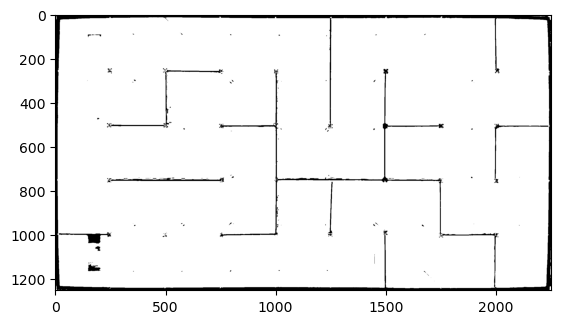

In [38]:
# # perspective transform
# image = cv2.imread(image_file)
# pts1 = np.float32([[430,265],[3445,265],[430,1960],[3445,1960]]) # original img corners
# pts2 = np.float32([[0,0],[2250,0],[0,1250],[2250,1250]]) # warped corners

# H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix
# print(H)

# warped_img = cv2.warpPerspective(image, H, (2251,1251)) # 250*9 x 250*5

hsv_img = cv2.cvtColor(warped_img, cv2.COLOR_BGR2HSV)
hsv_low = np.array([8,0,120],np.uint8)
hsv_high = np.array([99,255,235],np.uint8)
mask = cv2.inRange(hsv_img,hsv_low,hsv_high)
height, width,_ = warped_img.shape
color_img = np.ones((height,width,3),dtype=np.uint8) * 255
color_img[mask==0] = [0,0,0]
plt.imshow(color_img)
plt.show()


In [39]:
def generate_buffer_zone(img, kernels, iteration, minObs):
    kernel = np.ones((kernels, kernels), np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, obstacle = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(obstacle, connectivity=8)
    large_obstacles_mask = np.zeros_like(obstacle)
    for i in range(1, num_labels):  
        if stats[i, cv2.CC_STAT_AREA] > minObs:
            large_obstacles_mask[labels == i] = 255
    unsafe_zone = cv2.dilate(large_obstacles_mask, kernel, iterations=iteration)
    unsafe_mask = np.logical_and(unsafe_zone == 255, obstacle == 0)
    img[unsafe_mask] = [255, 0, 0]  
    return img

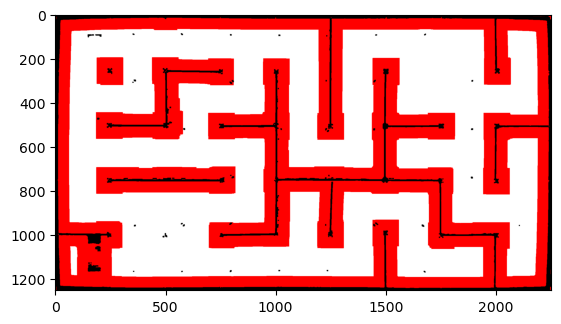

In [40]:
kernel = np.ones((7, 7), np.uint8)
kernel3 = np.ones((3, 3), np.uint8)
kernel2 = np.ones((2, 2), np.uint8)
kernel4 = np.ones((4, 4), np.uint8)
kernel5 = np.ones((1, 1), np.uint8)

image = color_img.copy()
dilated_image = cv2.dilate(image, kernel2, iterations = 1)
erode_image = cv2.erode(dilated_image, kernel3, iterations = 2)
buffer_image = generate_buffer_zone(erode_image,100,1,350)

plt.imshow(buffer_image)
plt.show()

In [43]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x, self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {} # Keys are node IDs, Values are node objects
        self.edges = {} # Keys are node IDs, Values are objects containing neighbouring node ID and the weight

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            # Edges are bi-directional
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            # Edges are bi-directional
            del self.edges[node_id1][node_id2]
            del self.edges[node_id2][node_id1]
    
    def get_nodes(self):
        return list(self.nodes.keys())
    
    def get_edge_weight(self, node_id1, node_id2):
        if node_id1 in self.edges and node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None
    
    def get_nodes_dict(self):
        return self.nodes
    
    def get_edges_dict(self):
        return self.edges

In [44]:
def path_clear(image,x1, y1, x2, y2):
    num_points = int(np.hypot(x2 - x1, y2 - y1)) + 1
    for i in range(num_points):
        t = i / num_points
        x = int(x1 + t * (x2 - x1))
        y = int(y1 + t * (y2 - y1))
        if not (0 <= x < image.shape[1] and 0 <= y < image.shape[0]):
            return False  
        if np.array_equal(image[y,x], [255, 0, 0]) or np.array_equal(image[y,x], [0, 0, 0]):
            return False
    return True

def find_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def prm_path_clear(image, x1, y1, x2, y2):
    
    distance = int(round(find_distance(x1, y1, x2, y2)))
    
    x_points = np.linspace(x1, x2, distance)
    y_points = np.linspace(y1, y2, distance)
    
    x_points = np.round(x_points).astype(int)
    y_points = np.round(y_points).astype(int)
    
    last_val = None
    for x, y in zip(x_points, y_points):
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            if last_val is None:
                last_val = image[y, x].any()
            else:
                if last_val != image[y, x].any():
                    return False
                else: 
                    last_val = image[y, x].any()

    return True

def find_neighbours(graph, node_id):
    neighbours = []
    nodes = graph.get_nodes()
    for node in nodes:
        print('4')
        if graph.get_edge_weight(node_id, node) is not None and node != node_id:
            neighbours.append(node_id)
    return neighbours

def dijkstra(graph, start_id, goal_id):
    queue = [(0, start_id)]
    distances = {node.get_ID(): float('inf') for node in list(graph.get_nodes_dict().values())}
    distances[start_id] = 0
    parent = {node.get_ID(): None for node in list(graph.get_nodes_dict().values())}
    while queue:
        current_distance, current_id = heapq.heappop(queue)        
        if current_id == goal_id:
            break       
        for neighbor_id, weight in graph.edges[current_id].items():
            distance = current_distance + weight            
            if distance < distances[neighbor_id]:
                distances[neighbor_id] = distance
                parent[neighbor_id] = current_id
                heapq.heappush(queue, (distance, neighbor_id))    
    path = []
    current_id = goal_id
    while parent[current_id] is not None:
        path.insert(0, current_id)
        current_id = parent[current_id]
    path.insert(0, start_id)   
    return path, distances[goal_id]


['t180.0', 'f250.0', 't90.0', 'f250.0', 't-90.0', 'f250.0', 't0.0', 'f250.0', 't0.0', 'f250.0', 't90.0', 'f250.0', 't0.0', 'f250.0', 't-270.0', 'f250.0', 't0.0', 'f250.0', 't270.0', 'f250.0', 't-90.0', 'f250.0', 't0.0', 'f250.0', 't90.0', 'f250.0', 't-270.0', 'f250.0', 't270.0', 'f250.0', 't-270.0', 'f250.0', 't90.0', 'f250.0', 't-90.0', 'f250.0', 't270.0', 'f250.0', 't-270.0', 'f250.0', 't90.0', 'f250.0', 't0.0', 'f250.0', 't0.0', 'f250.0', 't90.0', 'f250.0', 't-90.0', 'f250.0', 't-90.0', 'f250.0', 't90.0', 'f250.0']


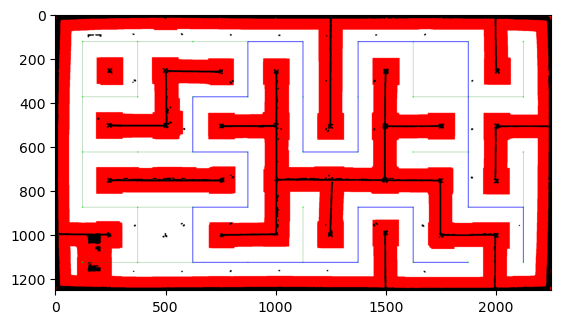

In [47]:
# grid_image = buffer_image.copy()
# # grid_image = cv2.cvtColor(erode123, cv2.COLOR_HSV2BGR)
# height = grid_image.shape[1]
# width = grid_image.shape[0]
# # node_spacing_x = (width // (size_of_node_grid + 1))
# # node_spacing_y = (height // (size_of_node_grid + 1))

# x_nodes = 9
# y_nodes = 5

# node_spacing_x = width // (x_nodes + 1)
# node_spacing_y = height // (y_nodes + 1)

# # spacing right now is hard coded, need to watch out if the camera shifts or anything when taking photo

# custom_node_spacing_y = 250
# custom_node_spacing_x = 2250 // 9

# bfs_graph = Graph()

# # The following loops were generated with the help of ChatGPT:]

# node_id = 0
# for i in range(y_nodes):
#     for j in range(x_nodes):
#         x = 125 + j * custom_node_spacing_x
#         y = 125 + i * custom_node_spacing_y
         
#         bfs_graph.add_node(node_id, x, y)
#         node_id += 1

# # Creating nodes
# # node_id = 0
# # for i in range(1, size_of_node_grid + 1):
# #     for j in range(1, size_of_node_grid + 1):
# #         x = j * node_spacing_x
# #         y = i * node_spacing_y
         
# #         bfs_graph.add_node(node_id, x, y)
# #         node_id += 1

# # # Adding edges
# # for i in range(size_of_node_grid):
# #     for j in range(size_of_node_grid):
# #         current_node_id = i * size_of_node_grid + j
# #         x, y = bfs_graph.nodes[current_node_id].get_point()
# #         # Connecting to the right with a weight of 1
# #         if j + 1 < size_of_node_grid:
# #             right_node_id = current_node_id + 1
# #             if path_clear(grid_image, x, y, x + node_spacing_x, y):
# #                 bfs_graph.add_edge(current_node_id, right_node_id, 1)
# #         # Connecting down with a weight of 1
# #         if i + 1 < size_of_node_grid:
# #             down_node_id = current_node_id + size_of_node_grid
# #             if path_clear(grid_image, x, y, x, y + node_spacing_y):
# #                 bfs_graph.add_edge(current_node_id, down_node_id, 1)

# nodes = bfs_graph.get_nodes()


# for node_id in nodes:
#     node_x, node_y = bfs_graph.nodes[node_id].get_point()
#     if node_id + 1 in nodes and node_id not in [8, 17, 26, 35, 44] != 0:
#         right_node_x, right_node_y = bfs_graph.nodes[node_id + 1].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, right_node_x, right_node_y):
#             bfs_graph.add_edge(node_id, node_id + 1, 1)
#     if node_id + 9 in nodes:
#         down_node_x, down_node_y = bfs_graph.nodes[node_id + 9].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, down_node_x, down_node_y):
#             bfs_graph.add_edge(node_id, node_id + 9, 1)

#     for node_id_2 in nodes:
#         if node_id_2 == node_id:
#             continue
#         node_2_x, node_2_y = bfs_graph.nodes[node_id_2].get_point()
#         if prm_path_clear(grid_image, node_x, node_y, node_2_x, node_2_y) and path_clear(grid_image, node_x, node_y, node_2_x, node_2_y):
#             bfs_graph.add_edge(node_id, node_id_2, find_distance(node_x, node_y, node_2_x, node_2_y))

# # Displaying nodes as light green circles with radius 3
# for node_id in bfs_graph.get_nodes():
#     node_obj = bfs_graph.nodes[node_id]
#     x,y = node_obj.get_point();
#     cv2.circle(grid_image, node_obj.get_point(), 3, (0, 255, 0), -1)

# # Displaying edges as dark green lines with width 1
# for node_id in bfs_graph.get_nodes():
#     for neighbour_id, weight in bfs_graph.edges[node_id].items():
#         node_obj = bfs_graph.nodes[node_id]
#         neighbour_obj = bfs_graph.nodes[neighbour_id]
#         cv2.line(grid_image, node_obj.get_point(), neighbour_obj.get_point(), (0, 125, 0), 1)

# # Labeling first and last nodes
# # cv2.putText(grid_image, '0', bfs_graph.nodes[0].get_point(), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
# # cv2.putText(grid_image, '99', bfs_graph.nodes[size_of_node_grid*size_of_node_grid - 1].get_point(), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# # continuous part starts on the 6th column and ends on the 9th

# # nodes: 5 + 9... 

# continuous_start = list(range(5, 42, 9))

# # for i in continuous_start:
# #     path, cost = dijkstra(bfs_graph, 0, i)
# #     if path:
# #         for node in path: 
# #             if node in continuous_start and node != path[-1]:
# #                 # if a valid path is found, but the path goes through the continuous start, don't use this path
# #                 # and keep searching for a path that starts at tge continuous part
# #                 continue
# #         break

# path, cost = dijkstra(bfs_graph, 0, 8)

# print(path)

# # converting path to commands
# # looking at our code right now, i think there are 2 options
# # 1. make the turning function be able to turn to any orientation (need it for continuous planning anyways),
# #    then we can just call move forward and turn to whatever orientation we need
# # 2. if we want to keep the maze movement as just forward, left and right then we'd need to keep track of 
# #    the robots current orientation

# # could try 2 since its simpler rn and we alr have turn left turn right
# # for 2: 
# # could identify 0, 1, 2, 3 as forward, right, down, left from the robot's current orientation, then
# # keep track of the robot's current orientation and do (turn direction = global direction - current orientation)
# # e.g. say robot's facing down (2), and the next path is right (1), then 1 - 2 = -1 + 4 = 3 therefore need to 
# #      turn left

# # + 4 if negative until positive

# # now we have to consider that the dijkstra paths don't just go to the nearest node in the maze, it goes to the 
# # cheapest one so it might jump directly

# commands = []

# # 0: up
# # 1: right
# # 2: down
# # 3: left
# # from perspective of camera

# start_dir = 2

# if start_dir == 0:
#     curr_angle = 90.0
# elif start_dir == 1: 
#     curr_angle = 0.0 
# elif start_dir == 2: 
#     curr_angle = -90.0
# elif start_dir == 3: 
#     curr_angle = 180.0

# # for i in range(1, len(path)):
# #     last_node = bfs_graph.nodes[path[i - 1]]
# #     curr_node = bfs_graph.nodes[path[i]]
# #     cv2.line(grid_image, curr_node.get_point(), last_node.get_point(), (0, 0, 255), 2)
    
# #     if curr_node.get_point()[0] - last_node.get_point()[0] < 0:
# #         global_dir = 3
# #     elif curr_node.get_point()[0] - last_node.get_point()[0] > 0:
# #         global_dir = 1
# #     elif curr_node.get_point()[1] - last_node.get_point()[1] < 0: 
# #         global_dir = 0
# #     elif curr_node.get_point()[1] - last_node.get_point()[1] > 0: 
# #         global_dir = 2
        
# #     if i == 1: 
# #         last_dir = start_dir
# #     else: 
# #         if bfs_graph.nodes[path[i-1]].get_point()[0] - bfs_graph.nodes[path[i-2]].get_point()[0] < 0:
# #             last_dir = 3
# #         elif bfs_graph.nodes[path[i-1]].get_point()[0] - bfs_graph.nodes[path[i-2]].get_point()[0] > 0:
# #             last_dir = 1
# #         elif bfs_graph.nodes[path[i-1]].get_point()[1] - bfs_graph.nodes[path[i-2]].get_point()[1] < 0: 
# #             last_dir = 0
# #         elif bfs_graph.nodes[path[i-1]].get_point()[1] - bfs_graph.nodes[path[i-2]].get_point()[1] > 0: 
# #             last_dir = 2
    
# #     next_dir = global_dir - last_dir
    
# #     if next_dir < 0: 
# #         next_dir += 4

# #     # t for turn, f for forward

# #     if next_dir == 1: 
# #         commands.append('r')
# #     elif next_dir == 2: 
# #         commands.append('rr')
# #     elif next_dir == 3:
# #         commands.append('l')
# #     commands.append(str(find_distance(curr_node.get_point()[0], curr_node.get_point()[1], last_node.get_point()[0], last_node.get_point()[1])))

# for i in range(1, len(path)):
#     last_node = bfs_graph.nodes[path[i - 1]]
#     curr_node = bfs_graph.nodes[path[i]]
#     cv2.line(grid_image, curr_node.get_point(), last_node.get_point(), (0, 0, 255), 2)
    
#     # -1 * (curr_y - last_y) as the y axis is inverted
#     angle = math.degrees(math.atan2(-1 * (curr_node.get_point()[1] - last_node.get_point()[1]), curr_node.get_point()[0] - last_node.get_point()[0]))
#     print(angle)
    
#     turn_angle = angle - curr_angle
#     curr_angle = angle

#     # t for turn, f for forward
    
#     commands.append('t' + str(turn_angle))
#     commands.append('f' + str(find_distance(curr_node.get_point()[0], curr_node.get_point()[1], last_node.get_point()[0], last_node.get_point()[1])))


# print(commands)

# with open('output.txt', 'w+') as f:
#     f.write(str(commands))
#     f.close()
    
# # Displaying resulting image
# plt.imshow(grid_image)
# plt.show()



grid_image = buffer_image.copy()
height = grid_image.shape[1]
width = grid_image.shape[0]

x_nodes = 9
y_nodes = 5

node_spacing_x = width // (x_nodes + 1)
node_spacing_y = height // (y_nodes + 1)

custom_node_spacing_y = 250
custom_node_spacing_x = 2250 // 9

bfs_graph = Graph()

# Adding nodes to the graph
node_id = 0
for i in range(y_nodes):
    for j in range(x_nodes):
        x = 125 + j * custom_node_spacing_x
        y = 125 + i * custom_node_spacing_y
        bfs_graph.add_node(node_id, x, y)
        node_id += 1

# Adding edges only horizontally and vertically
for i in range(y_nodes):
    for j in range(x_nodes):
        current_node_id = i * x_nodes + j
        x, y = bfs_graph.nodes[current_node_id].get_point()

        # Connect to the right neighbor
        if j + 1 < x_nodes:
            right_node_id = current_node_id + 1
            if prm_path_clear(grid_image, x, y, x + custom_node_spacing_x, y):
                bfs_graph.add_edge(current_node_id, right_node_id, 1)

        # Connect to the bottom neighbor
        if i + 1 < y_nodes:
            down_node_id = current_node_id + x_nodes
            if prm_path_clear(grid_image, x, y, x, y + custom_node_spacing_y):
                bfs_graph.add_edge(current_node_id, down_node_id, 1)

# Displaying nodes as light green circles with radius 3
for node_id in bfs_graph.get_nodes():
    node_obj = bfs_graph.nodes[node_id]
    cv2.circle(grid_image, node_obj.get_point(), 3, (0, 255, 0), -1)

# Displaying edges as dark green lines with width 1
for node_id in bfs_graph.get_nodes():
    for neighbour_id, weight in bfs_graph.edges[node_id].items():
        node_obj = bfs_graph.nodes[node_id]
        neighbour_obj = bfs_graph.nodes[neighbour_id]
        cv2.line(grid_image, node_obj.get_point(), neighbour_obj.get_point(), (0, 125, 0), 1)

# The rest of your code for pathfinding and displaying the result remains unchanged
path, cost = dijkstra(bfs_graph, 44, 43)

# Converting path to commands
commands = []
start_dir = 2

if start_dir == 0:
    curr_angle = 90.0
elif start_dir == 1: 
    curr_angle = 0.0 
elif start_dir == 2: 
    curr_angle = -90.0
elif start_dir == 3: 
    curr_angle = 180.0

for i in range(1, len(path)):
    last_node = bfs_graph.nodes[path[i - 1]]
    curr_node = bfs_graph.nodes[path[i]]
    cv2.line(grid_image, curr_node.get_point(), last_node.get_point(), (0, 0, 255), 2)
    
    angle = math.degrees(math.atan2(-1 * (curr_node.get_point()[1] - last_node.get_point()[1]), curr_node.get_point()[0] - last_node.get_point()[0]))
    
    turn_angle = angle - curr_angle
    curr_angle = angle

    commands.append('t' + str(turn_angle))
    commands.append('f' + str(find_distance(curr_node.get_point()[0], curr_node.get_point()[1], last_node.get_point()[0], last_node.get_point()[1])))

print(commands)

with open('output.txt', 'w+') as f:
    f.write(str(commands))
    f.close()

# Displaying resulting image
plt.imshow(grid_image)
plt.show()
